# Project : Email Spam Classification

![image](image.png)


In [3]:
#import lab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer

## 1. Collecting Data

In [4]:
#Load Dataset 
df = pd.read_csv('./spam_ham_dataset.csv', encoding='latin-1')

## 2. Data Preprocessing

In [5]:
df.columns

Index(['Unnamed: 0', 'label', 'text', 'label_num'], dtype='object')

In [6]:
# preview data
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [7]:
# remove feature not important 
columns_remove = ['Unnamed: 0']
df = df.drop(columns_remove, axis=1)

In [8]:
# preview data
df.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [9]:
df['label_num'].value_counts()

0    3672
1    1499
Name: label_num, dtype: int64

In [10]:
# missing values
df.isnull().sum()

label        0
text         0
label_num    0
dtype: int64

In [11]:
# check for duplicate values
df.duplicated().sum()

178

In [12]:
df = df.drop_duplicates()

In [13]:
# check for duplicate values
df.duplicated().sum()

0

In [14]:
df['label_num'].value_counts()

0    3531
1    1462
Name: label_num, dtype: int64

<Axes: >

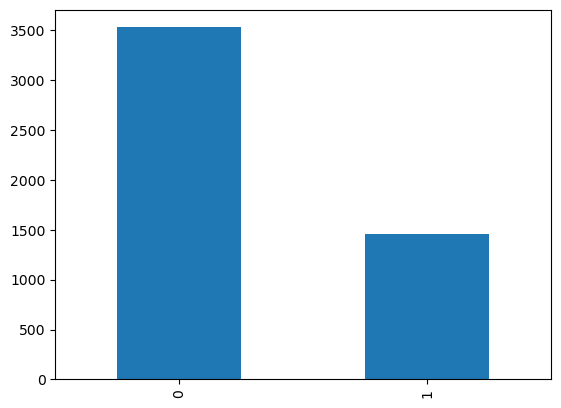

In [15]:
df['label_num'].value_counts().plot(kind="bar")

In [16]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    # Retaining only numbers and alphabets
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    # Clone copy of list y
    text = y[:]
    y.clear()
    
    # Stopwords removal and removal of special characters/punctuation
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    # Lemmatization
    for i in text:
        y.append(lemmatizer.lemmatize(i)) 
        
    text = y[:]
    y.clear()
    
    # Remove 'Subject' using replace
    text = [token.replace('subject', '') for token in text]
    
    return " ".join(text)


[nltk_data] Downloading package punkt to C:\Users\Brak
[nltk_data]     Lihou\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Brak
[nltk_data]     Lihou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Brak
[nltk_data]     Lihou\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [109]:
transform_text( "Subject: enron methanol ; meter # : 988291\r\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to reflect daily\r\nactivity you can obtain from gas control .\r\nthis change is needed asap for economics purposes .")

' enron methanol meter 988291 follow note gave monday 4 3 00 preliminary flow data provided daren please override pop daily volume presently zero reflect daily activity obtain gas control change needed asap economics purpose'

In [110]:
df['text'][0]

"Subject: enron methanol ; meter # : 988291\r\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to reflect daily\r\nactivity you can obtain from gas control .\r\nthis change is needed asap for economics purposes ."

In [19]:
df['text_transform'] = df['text'].apply(transform_text)

In [20]:
df

,label,text,label_num,text_transform
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,enron methanol meter 988291 follow note gave ...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,hpl nom january 9 2001 see attached file hpln...
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,neon retreat ho ho ho around wonderful time y...
3,spam,"Subject: photoshop , windows , office . cheap ...",1,photoshop window office cheap main trending a...
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,indian spring deal book teco pvr revenue unde...
...,...,...,...,...
5165,ham,"Subject: fw : crosstex energy , driscoll ranch...",0,fw crosstex energy driscoll ranch 1 3 meter n...
5166,ham,Subject: put the 10 on the ft\r\nthe transport...,0,put 10 ft transport volume decreased 25000 10...
5167,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0,3 4 2000 following noms hpl take extra 15 mmc...
5169,ham,Subject: industrial worksheets for august 2000...,0,industrial worksheet august 2000 activity att...


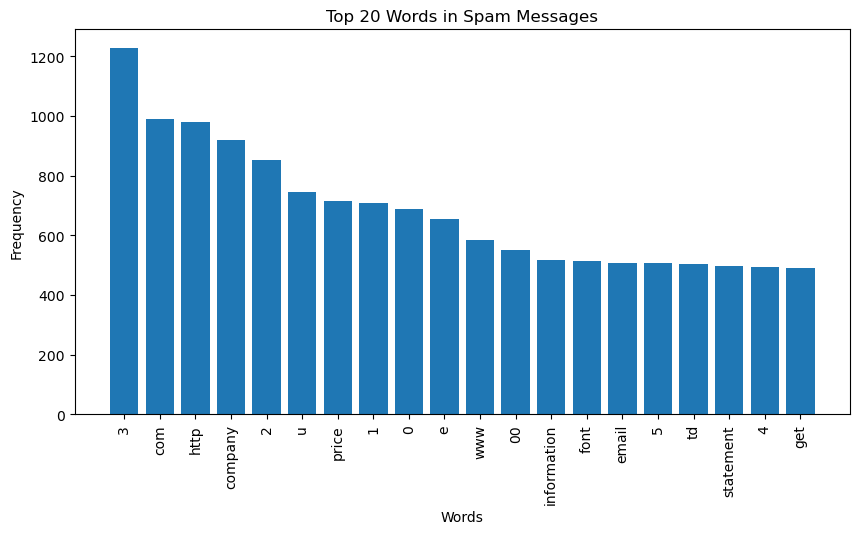

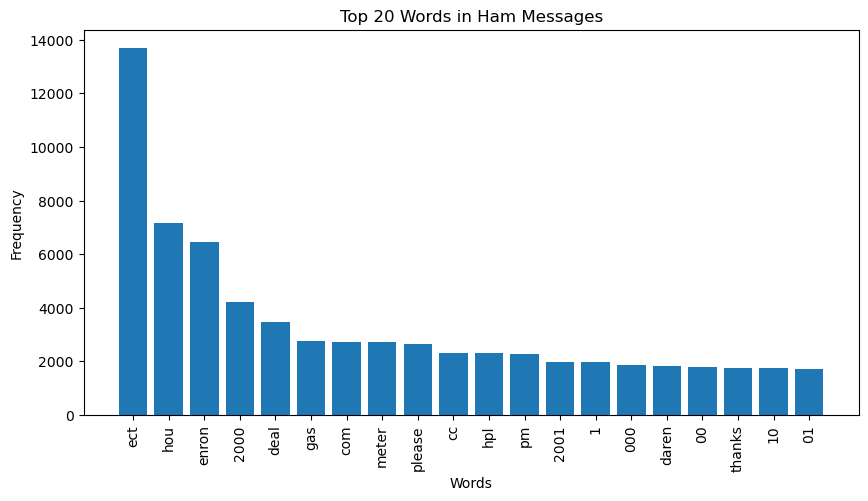

In [21]:
import nltk
import matplotlib.pyplot as plt

spam_words = []
ham_words = []

for _, row in df.iterrows():
    text = row['text_transform']
    label = row['label']

    words = text.split()

    if label == 'spam':
        spam_words.extend(words)
    else:
        ham_words.extend(words)

# Create frequency distributions for spam and ham words
spam_freq_dist = nltk.FreqDist(spam_words)
ham_freq_dist = nltk.FreqDist(ham_words)

# Get the top 20 most common words in spam messages
top_spam_words = spam_freq_dist.most_common(20)
# Separate the words and their frequencies
spam_words, spam_counts = zip(*top_spam_words)

# Get the top 20 most common words in ham messages
top_ham_words = ham_freq_dist.most_common(20)
# Separate the words and their frequencies
ham_words, ham_counts = zip(*top_ham_words)

# Plot the most common words in spam messages
plt.figure(figsize=(10, 5))
plt.bar(spam_words, spam_counts)
plt.title('Top 20 Words in Spam Messages')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

# Plot the most common words in ham messages
plt.figure(figsize=(10, 5))
plt.bar(ham_words, ham_counts)
plt.title('Top 20 Words in Ham Messages')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


In [140]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train_text, X_test_text, y_train, y_test = train_test_split(df['text_transform'], df['label_num'], test_size=0.2, random_state=42)

In [141]:
from sklearn.feature_extraction.text import CountVectorizer

# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

# Convert the training set text data to CountVectorizer vectors
X_train = vectorizer.fit_transform(X_train_text)

# Convert the testing set text data to CountVectorizer vectors
X_test = vectorizer.transform(X_test_text)

In [153]:
print(y_train.value_counts())
print(y_test.value_counts())

0    2799
1    1195
Name: label_num, dtype: int64
0    732
1    267
Name: label_num, dtype: int64


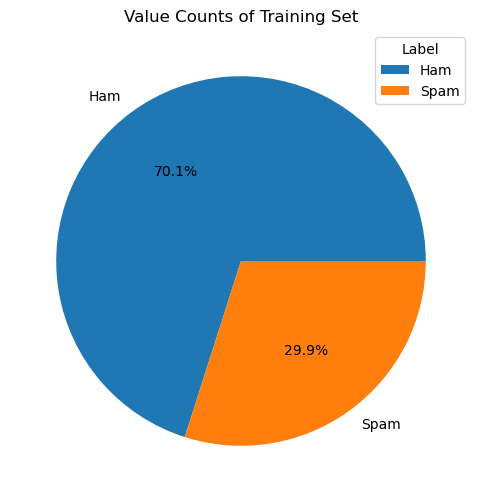

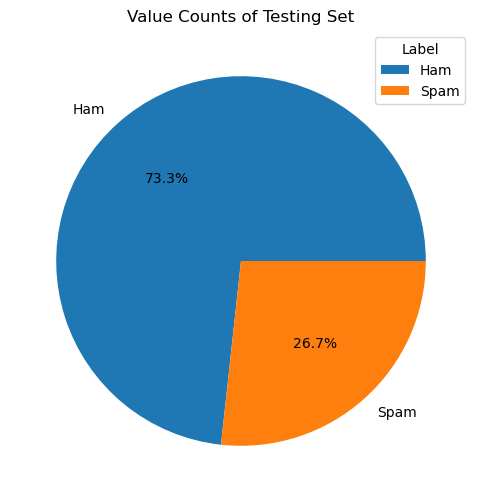

In [142]:
import matplotlib.pyplot as plt

# Define label names
label_names = {
    1: 'Spam',
    0: 'Ham'
}

# Check the value counts of the training set
train_label_counts = y_train.value_counts()

# Check the value counts of the testing set
test_label_counts = y_test.value_counts()

# Plot the value counts for the training set as a pie chart
plt.figure(figsize=(6, 6))
plt.pie(train_label_counts, labels=[label_names[label] for label in train_label_counts.index], autopct='%1.1f%%')
plt.title('Value Counts of Training Set')
plt.legend(title='Label')
plt.show()

# Plot the value counts for the testing set as a pie chart
plt.figure(figsize=(6, 6))
plt.pie(test_label_counts, labels=[label_names[label] for label in test_label_counts.index], autopct='%1.1f%%')
plt.title('Value Counts of Testing Set')
plt.legend(title='Label')
plt.show()


Random Forest (Test Set):
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       732
           1       0.94      0.96      0.95       267

    accuracy                           0.97       999
   macro avg       0.96      0.97      0.97       999
weighted avg       0.97      0.97      0.97       999



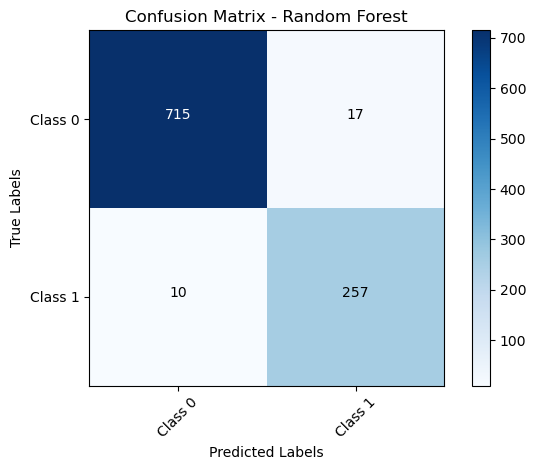


Logistic Regression (Test Set):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       732
           1       0.93      0.98      0.95       267

    accuracy                           0.97       999
   macro avg       0.96      0.98      0.97       999
weighted avg       0.98      0.97      0.98       999



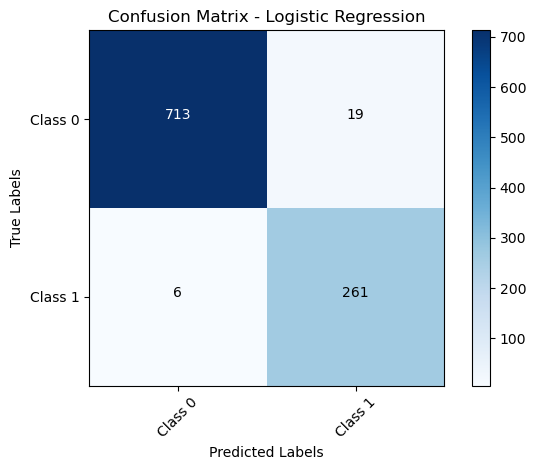


SVM (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       732
           1       0.88      0.99      0.93       267

    accuracy                           0.96       999
   macro avg       0.94      0.97      0.95       999
weighted avg       0.96      0.96      0.96       999



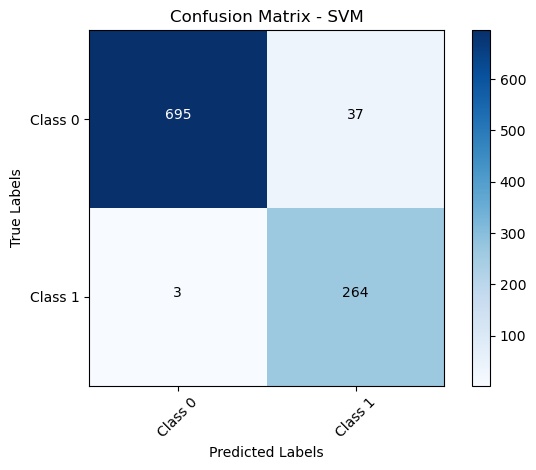


Naive Bayes (Test Set):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       732
           1       0.94      0.96      0.95       267

    accuracy                           0.97       999
   macro avg       0.96      0.97      0.97       999
weighted avg       0.97      0.97      0.97       999



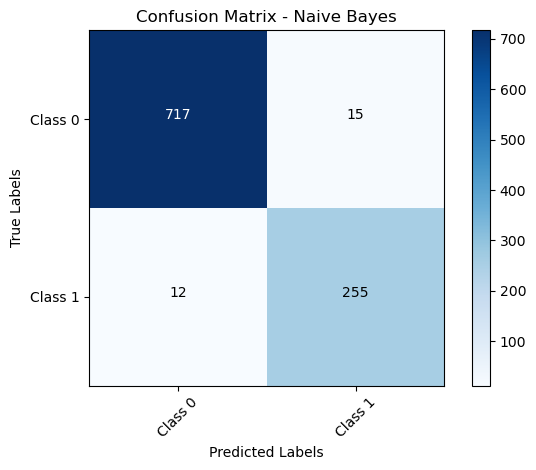

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Train Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Train Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Train SVM
svc_model = SVC()
svc_model.fit(X_train, y_train)

# Train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)
y_pred_lr = lr_model.predict(X_test)
y_pred_svc = svc_model.predict(X_test)
y_pred_nb = nb_model.predict(X_test)

# Calculate evaluation metrics on the test set
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

accuracy_svc = accuracy_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc, average='weighted')
recall_svc = recall_score(y_test, y_pred_svc, average='weighted')
f1_svc = f1_score(y_test, y_pred_svc, average='weighted')

accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb, average='weighted')
recall_nb = recall_score(y_test, y_pred_nb, average='weighted')
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')

# Define function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title):
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()

# Print classification report and plot confusion matrix for Random Forest
print("Random Forest (Test Set):")
print(classification_report(y_test, y_pred_rf))
confusion_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(confusion_rf, classes=['Class 0', 'Class 1'], title='Confusion Matrix - Random Forest')
print()

# Print classification report and plot confusion matrix for Logistic Regression
print("Logistic Regression (Test Set):")
print(classification_report(y_test, y_pred_lr))
confusion_lr = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(confusion_lr, classes=['Class 0', 'Class 1'], title='Confusion Matrix - Logistic Regression')
print()

# Print classification report and plot confusion matrix for SVM
print("SVM (Test Set):")
print(classification_report(y_test, y_pred_svc))
confusion_svc = confusion_matrix(y_test, y_pred_svc)
plot_confusion_matrix(confusion_svc, classes=['Class 0', 'Class 1'], title='Confusion Matrix - SVM')
print()

# Print classification report and plot confusion matrix for Naive Bayes
print("Naive Bayes (Test Set):")
print(classification_report(y_test, y_pred_nb))
confusion_nb = confusion_matrix(y_test, y_pred_nb)
plot_confusion_matrix(confusion_nb, classes=['Class 0', 'Class 1'], title='Confusion Matrix - Naive Bayes')
print()

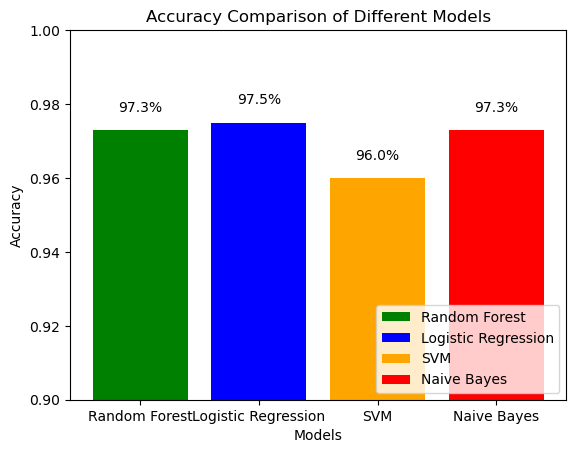

In [144]:
# Create a bar chart to compare accuracies
models = ['Random Forest', 'Logistic Regression', 'SVM', 'Naive Bayes']
accuracies = [accuracy_rf, accuracy_lr, accuracy_svc, accuracy_nb]
colors = ['green', 'blue', 'orange', 'red']

bars = plt.bar(models, accuracies, color=colors)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')

# Set y-axis limits and format percentages on bars
plt.ylim(0.9, 1.0)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.005, str(round(v*100, 2)) + '%', ha='center')

# Add legend with labels and adjust font size
plt.legend(bars, models, loc='lower right')

plt.show()

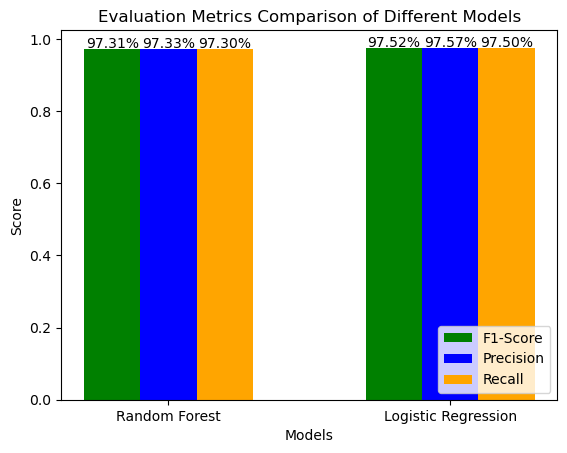

In [151]:
models = ['Random Forest', 'Logistic Regression']
metrics = ['F1-Score', 'Precision', 'Recall']
f1_scores = [f1_rf, f1_lr]
precisions = [precision_rf, precision_lr]
recalls = [recall_rf, recall_lr]
colors = ['green', 'blue', 'orange']

# Bar width
bar_width = 0.2

# Bar positions
bar_pos = np.arange(len(models))

# Plot bars for f1-scores
plt.bar(bar_pos, f1_scores, color=colors[0], width=bar_width, label=metrics[0])
# Plot bars for precisions
plt.bar(bar_pos + bar_width, precisions, color=colors[1], width=bar_width, label=metrics[1])
# Plot bars for recalls
plt.bar(bar_pos + 2*bar_width, recalls, color=colors[2], width=bar_width, label=metrics[2])

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Evaluation Metrics Comparison of Different Models')

# Set x-axis tick positions and labels
plt.xticks(bar_pos + bar_width, models)

# Add legend
plt.legend(loc='lower right')

# Add percentage values on bars
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.002, f'{v*100:.2f}%', color='black', ha='center')
for i, v in enumerate(precisions):
    plt.text(i + bar_width, v + 0.002, f'{v*100:.2f}%', color='black', ha='center')
for i, v in enumerate(recalls):
    plt.text(i + 2*bar_width, v + 0.002, f'{v*100:.2f}%', color='black', ha='center')

# Show the plot
plt.show()


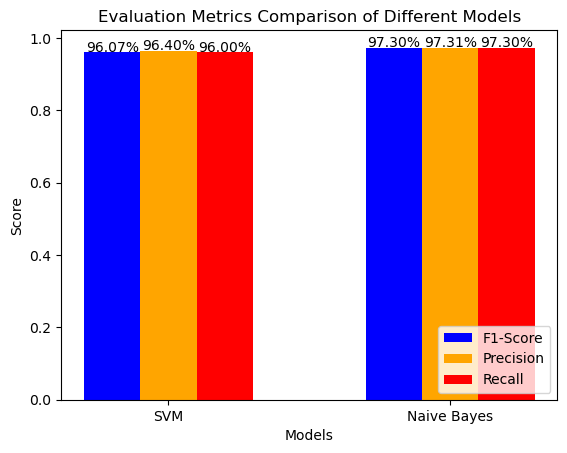

In [154]:
# Create a bar chart to compare f1-scores, precisions, and recalls
models = ['SVM', 'Naive Bayes']
metrics = ['F1-Score', 'Precision', 'Recall']
f1_scores = [f1_svc, f1_nb]
precisions = [precision_svc, precision_nb]
recalls = [recall_svc, recall_nb]
colors = ['blue', 'orange', 'red']

# Bar width
bar_width = 0.2

# Bar positions
bar_pos = np.arange(len(models))

# Plot bars for f1-scores
plt.bar(bar_pos, f1_scores, color=colors[0], width=bar_width, label=metrics[0])
# Plot bars for precisions
plt.bar(bar_pos + bar_width, precisions, color=colors[1], width=bar_width, label=metrics[1])
# Plot bars for recalls
plt.bar(bar_pos + 2*bar_width, recalls, color=colors[2], width=bar_width, label=metrics[2])

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Evaluation Metrics Comparison of Different Models')

# Set x-axis tick positions and labels
plt.xticks(bar_pos + bar_width, models)

# Add legend
plt.legend(loc='lower right')

# Add percentage values on bars
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.002, f'{v*100:.2f}%', color='black', ha='center')
for i, v in enumerate(precisions):
    plt.text(i + bar_width, v + 0.002, f'{v*100:.2f}%', color='black', ha='center')
for i, v in enumerate(recalls):
    plt.text(i + 2*bar_width, v + 0.002, f'{v*100:.2f}%', color='black', ha='center')

# Show the plot
plt.show()


In [156]:
messages = [
# Spam 

"""Subject: "Get Rich Quick!"
Body: "Make thousands of dollars in just a few days! Don't miss this amazing opportunity. Click here to learn more."
""",
"""Subject: "You've won a free vacation!"
Body: "Congratulations! You've been selected as the lucky winner of a free vacation package. Claim your prize now by providing your details.""",

# Ham

""" Subject: "Meeting reminder for tomorrow"
Body: "Just a friendly reminder that we have a team meeting scheduled for tomorrow at 10 AM in the conference room. Please come prepared."
""",

"""Subject: "Invitation to our charity event"
Body: "You are cordially invited to attend our annual charity event to support a good cause. Join us on [date] at [location]. We look forward to seeing you there."
"""
]
# Transform the new emails using the same CountVectorizer instance
email_clean = [transform_text(email) for email in messages]

transformed_emails = vectorizer.transform(email_clean)

# Predict using the transformed data
rf_predictions = rf_model.predict(transformed_emails)
lr_predictions = lr_model.predict(transformed_emails)
svc_predictions = svc_model.predict(transformed_emails)
nb_predictions = nb_model.predict(transformed_emails)

print("Random Forest Predictions:", rf_predictions)
print("Logistic Regression Predictions:", lr_predictions)
print("Support Vector Machine Predictions:", svc_predictions)
print("Naive Bayes Predictions:", nb_predictions)

Random Forest Predictions: [1 1 0 1]
Logistic Regression Predictions: [1 1 0 1]
Support Vector Machine Predictions: [1 1 0 1]
Naive Bayes Predictions: [1 1 0 1]
